In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy import signal
import numpy.random as rnd
import pandas as pd

plt.rcParams["figure.figsize"] = (12,8)

# Lab 3
## Problem 1

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

A) So our goal is to identify bad data and throw it out.

1.) Start by exploring the data you have created with appropriate plots

2.) State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.

3.) Restate your question in math. Be very clear.

4.) Apply your statistical test and construct a truth table.

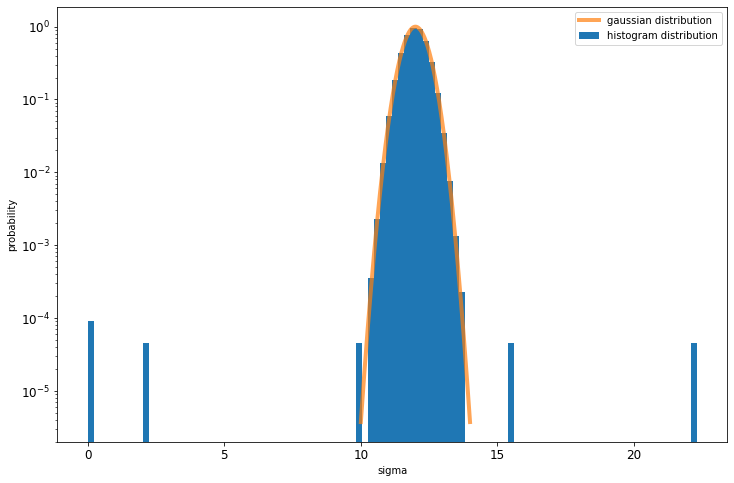

In [2]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)

ax.hist(d,100, density=True, label = 'histogram distribution')
plt.tick_params(labelsize = 12)
plt.yscale('log')

ax.set_xlabel('sigma')
ax.set_ylabel('probability')

x = np.linspace(10, 14, len(d)) #5sigma = 5 * .4 = 2, 12 +- 2 = 10, 14
g = (stats.norm(12, .4).pdf(x))

ax.plot(x,g, linewidth = 4,alpha = 0.7, label = 'gaussian distribution')
plt.legend()
plt.show()


Our statistical question would be "What would the significance that our test has shown errors within holding temperature be, both with and without proper temperature maintainence? How can we find these errors?" We can answer this by fitting a gaussian to this data and then filtering out from d points that do not fit under this curve. The test in question is below:

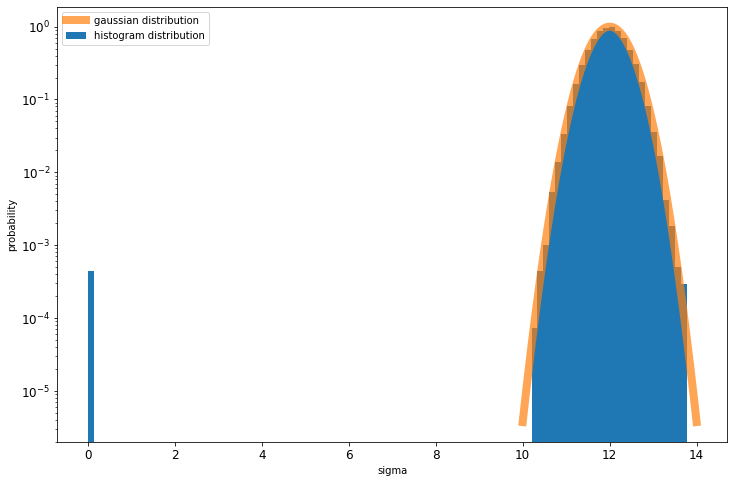

In [3]:
temp_test = np.where(d < 14, d, np.zeros(len(d)))
temp_test = np.where(temp_test > 10, temp_test, np.zeros(len(temp_test)))

fig, ax = plt.subplots(1,1)

ax.hist(temp_test,100, density=True, label = 'histogram distribution')
plt.tick_params(labelsize = 12)
plt.yscale('log')

ax.set_xlabel('sigma')
ax.set_ylabel('probability')

x = np.linspace(10, 14, len(d)) #5sigma = 5 * .4 = 2, 12 +- 2 = 10, 14
g = (stats.norm(12, .4).pdf(x))

ax.plot(x,g, linewidth = 8,alpha = 0.7, label = 'gaussian distribution')
plt.legend()
plt.show()

In [4]:
l_b = 10
r_b = 14

ytg_tt = len(np.where((temp_test > l_b) & (temp_test < r_b))[0]) - 2
ytb_ft = np.where(temp_test == 0)
ytg_ft = 0
ytb_tt = 2

yt_dict = {'True T':[ytg_tt, ytg_ft], 
            'Bad T':[ytb_tt, len(ytb_ft[0])]}

temp_df = pd.DataFrame(yt_dict)
temp_df.index = ['Your Test Good', 'Your Test Bad']

In [5]:
temp_df

,True T,Bad T
Your Test Good,100000,2
Your Test Bad,0,6


In [6]:
ytg_tt = np.where((temp_test > l_b) & (temp_test < r_b))
ytg_tt

(array([     0,      1,      2, ...,  99999, 100001, 100007]),)

B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?

The number of omissions where we threw out good data depends on the statistical threshold in such a way that if we reduced the threshold in which we filtered in (ex. sigma 10-14 to 11-13), the amount of good data that would be thrown out increases. It is predictable because the good data that is thrown out can be found by the area under the curve between both the tail of the gaussian curve and our new threshold.

C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?

Yes, there is some bad data getting in, and they are not completely avoidable if they fall under your desired threshold. They can be filtered out by decreasing the threshold, but good data will also be filtered out.

## Problem 2
In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

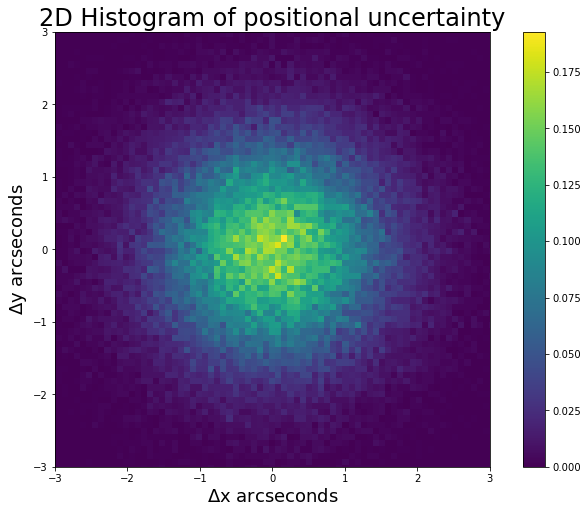

In [7]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

1.)What is the question in words?

2.)What is the question in math? [Hint: Come up with an analytic description of your pdf(). The Blue Book may be helpful here.]

3.)What distance in arcseconds represents a 5 sigma detection of motion?

The question in words is "Our background, according to the sum of two 2D Gaussians, should be a Rayleigh distribution. What is the significance of our detection of movement? In other words, what is the 5sigma of the pdf of this Rayleigh distribution, and how does that translate to arcseconds?"

In math, our question becomes: "What is our 5-sigma?"

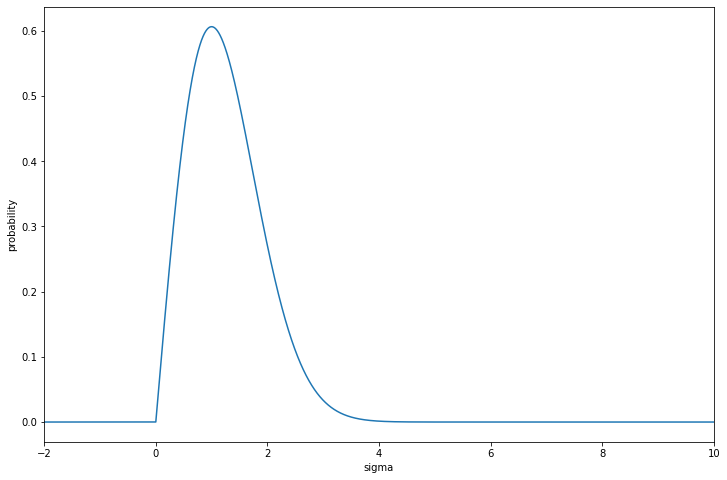

In [8]:
x = np.linspace(-10, 10, 100000)
sum_gaussian = stats.rayleigh(0,1).pdf(x)

fig, ax = plt.subplots(1,1)
ax.set_xlim(-2, 10)

ax.set_xlabel('sigma')
ax.set_ylabel('probability')

ax.plot(x, sum_gaussian)

In [9]:
five_sigma = stats.norm.ppf(stats.rayleigh(0,1).cdf(5))
five_sigma

4.4803146987717914

A 5 sigma detection of motion should be about 4.5 arcseconds.

## Problem 3

As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

As always:

1.)What is the question in words?

2.)Translate the question to math, describing both the expected background pdf() and the integral you need to do.

3.)Convert to sigma.

There are some unique aspects to this problem. Make sure you explore them in your explanation.

The question in words is: With a rate of 1 ray per minute over a 8 hour time period per 15 days, what is the chance that we see 6800 cosmic rays?

In math, the question becomes, what is the pdf of getting 6800 cosmic rays over this time period? How does the sigma that comes out of this integral compare to the 5-sigma?

In [11]:
cr_mu = 60 * 8
cr_x = np.linspace(stats.norm(cr_mu).ppf(.01), stats.norm(cr_mu).ppf(.99), 100000)
cr_dist = stats.norm(cr_mu).pdf(x)

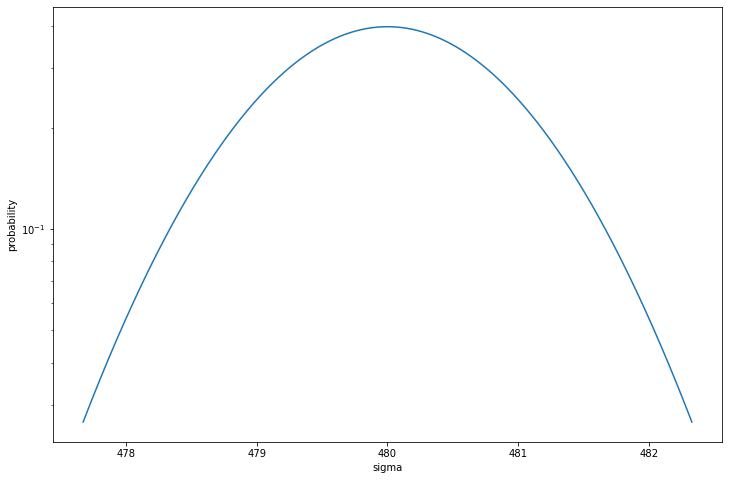

In [58]:
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.set_xlabel('sigma')
ax.set_ylabel('probability')

ax.plot(cr_x, cr_dist)

In [13]:
def convoluter (nconv, dist, mu):
    conv_last = dist
    for i in range(nconv):
        conv_new = signal.convolve(conv_last, dist)
        conv_last = conv_new
        #print('convolution' + str(i+1))

    x_new = np.linspace(stats.norm.ppf(0.01, mu), stats.norm.ppf(0.99, mu), np.size(conv_new))
    
    return conv_new, x_new

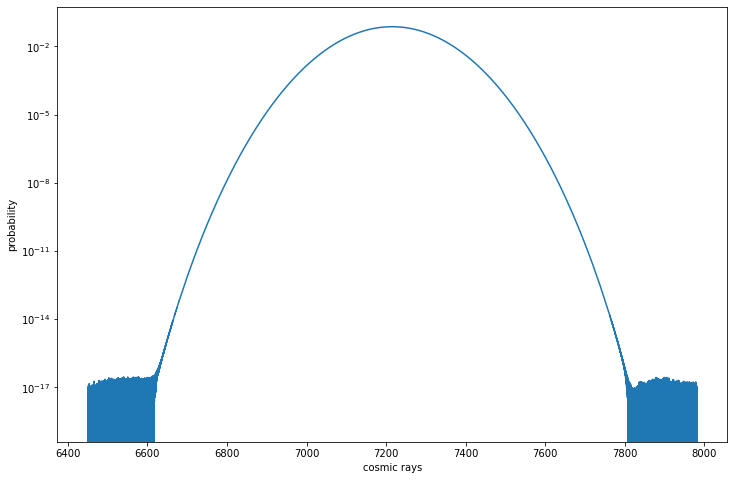

In [61]:
cr_conv, x_conv = convoluter(15, cr_dist, cr_mu)
x_cr_scaled = x_conv*15
cr_conv_scaled = cr_conv/1e65
fig, ax = plt.subplots(1,1)
ax.set_yscale('log')
ax.set_xlabel('cosmic rays')
ax.set_ylabel('probability')

ax.plot(x_cr_scaled, cr_conv_scaled)

In [48]:
val = np.where((x_cr_scaled > 6799) & (x_cr_scaled < 6801))[0]
#val = np.where(val > 6801)
#x_cr_scaled
np.median(val)

366009.5

In [49]:
x_cr_scaled[366010]

6800.000562505625

In [52]:
cr_conv_scaled[366010]

1.2953645221844362e-08

In [54]:
sigma = stats.norm(cr_mu).ppf(cr_conv_scaled[366010])
sigma

474.4329397957298

In [62]:
ms = stats.norm(cr_mu).ppf(cr_dist.max())
ms

479.7439141665179

The sigma we find is only about 5 less than the sigma of the most probable cosmic ray amount. The significance of obtaining 6800 cosmic rays is probable.